## RealNVP Example

**Note as of 20/10/2020** This notebook works with TFP 0.8 but it is assumned that it will change due to expected changes in the API of TFP.

**Goal:** This notebook shows how to wrap learnable flows into Keras **subclassing** `tf.keras.models.Model`. 

**Usage:** Try to understand the provided code.

**Dataset:** Two dimnesional artifical data.

**Content:**
* Generation of the 2 dimensional artificial data set
* Creating a RealVNP-Flow subclassing Keras
* Fitting the flow to the 2-dimensional data
* Bonus: Autoregressive Flow

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tqdm import tqdm
from time import time
from typing import *

tfb = tfp.bijectors
tfd = tfp.distributions
SEED = 1
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

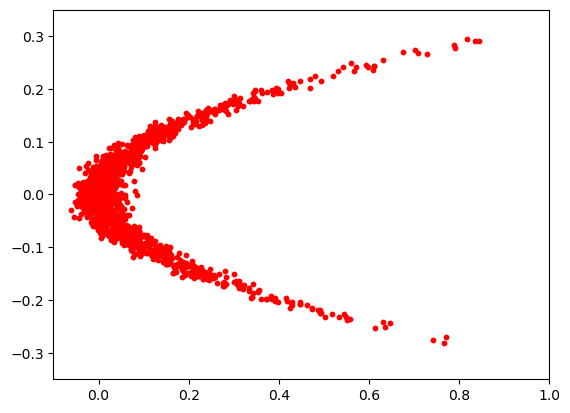

In [2]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem


def sample_2(batch_size: int = 500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1_dist = tfd.Normal(loc=0.25 * tf.square(x2_samples), scale=K.ones(batch_size, dtype=tf.float32))
    
    x1_samples = x1_dist.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy() / 40.0

with tf.device("/cpu:0"):
    X = sample_2(1500)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

(array([980., 375.,  91.,  38.,  10.,   4.,   1.,   0.,   0.,   1.]),
 array([-0.08113965,  0.09833328,  0.27780622,  0.45727915,  0.63675207,
         0.816225  ,  0.9956979 ,  1.1751709 ,  1.3546438 ,  1.5341167 ,
         1.7135897 ], dtype=float32),
 <BarContainer object of 10 artists>)

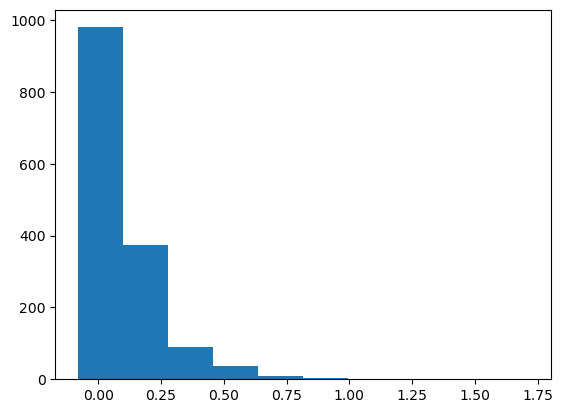

In [3]:
plt.hist(X[:, 0], bins=10)

In [9]:

class RealNVP(Model):

    def __init__(self, *, output_dim: int, num_masked: int, num_blocks: int = 5, hidden_units: int = 32, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []
        bijectors = []    # [RealNVP, Permute, ,..., RealNVP, Permute, RealNVP]
        for i in range(num_blocks): 
            net = tfb.real_nvp_default_template([hidden_units, hidden_units])
            setattr(self, f"nets_{i}", net)
            bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=net, num_masked=num_masked))
            bijectors.append(tfb.Permute([1, 0]))
            self.nets.append(net)
            
        self.bijector = tfb.Chain(bijectors[:-1][::-1])
        self.flow = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), bijector=self.bijector)

    def call(self, inputs): 
        return self.flow.bijector.forward(inputs)
    

model = RealNVP(output_dim=2, num_masked=1, num_blocks=5, hidden_units=32, name="real_nvp")
model.build(input_shape=(None, 2))

print(model.summary())

Model: "real_nvp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
optimizer = Adam(learning_rate=0.001)

@tf.function
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -K.mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()

for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time() - start))
        start = time()

0   1.8717958 1.2047419548034668
100   -1.8952135 1.74751877784729
200   -2.6595044 1.6420698165893555
300   -2.768457 1.631122350692749
400   -2.8928275 1.6226634979248047
500   -2.964178 1.6179933547973633
600   -3.0025074 1.6316273212432861
700   -3.032895 1.668811321258545
800   -3.0574424 1.6385033130645752
900   -3.0782042 1.6558754444122314
1000   -3.0985737 1.695192813873291


(-0.35, 0.35)

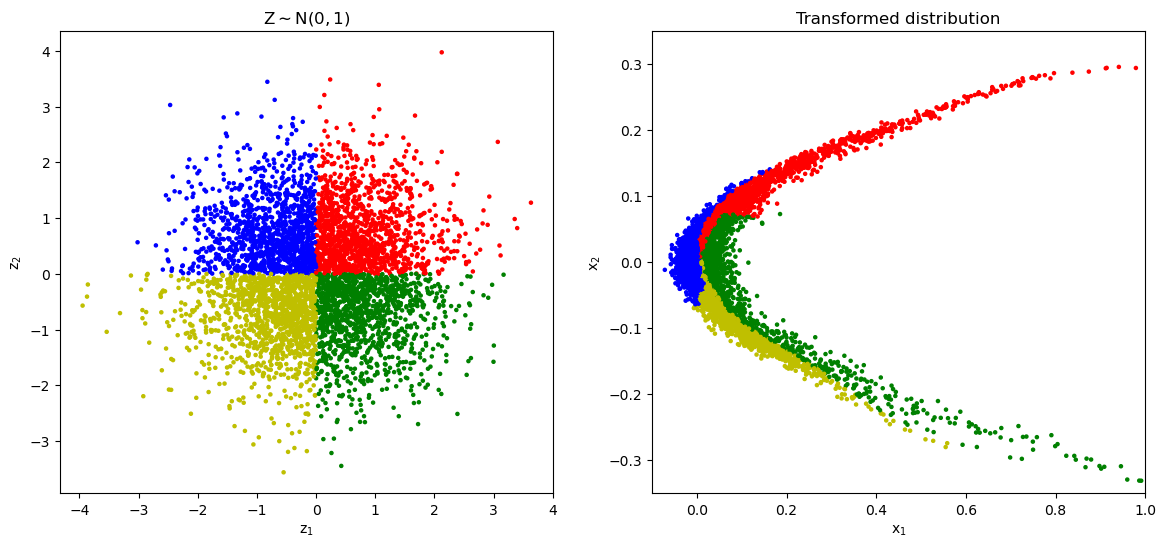

In [13]:
Z = np.random.normal(0, 1, (5000,2)).astype("float32")


def decide_color(row):
    if row[0] > 0 and row[1] > 0:
        return "r"
    if row[0] < 0 and row[1] > 0:
        return "b"
    if row[0] < 0 and row[1] < 0:
        return "y"
    return "g"


colors = [decide_color(x) for x in Z]
plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], s=5, c=colors)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1, 2, 2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=colors)
plt.xlim(-0.1, 1)
plt.ylim(-0.35, 0.35)

### Understanding the mixture

We redo the morphing between two point in the x-space. In our high dimensional examples, we went from Beyonce to DiCaprio. We now redo this morphing with the two dimensional example to understand the principle.


In [43]:
def generate_line_points(start, end, n: int):
    endpoints = np.vstack([start, end])
    r = np.linspace(0, 1, 500)[:, np.newaxis]
    r = np.hstack([1 - r, r])
    return r @ endpoints

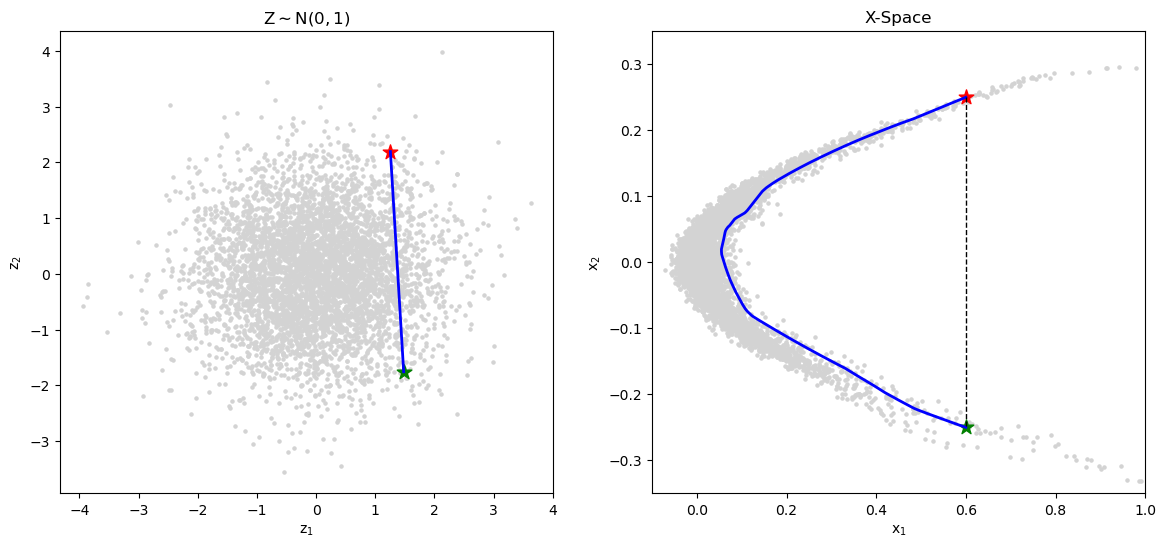

In [44]:

X1 = np.array((0.6, 0.25), dtype="float32")    #Starting point corresponing to Beyonce
X2 = np.array((0.6, -0.25), dtype="float32")   #End point corresponing to DiCaprio

Z1 = model.flow.bijector.inverse(X1)        # Same 
Z2 = model.flow.bijector.inverse(X2)


# generate the line between Z1 and Z2
nums = 500
Z_mixs = generate_line_points(Z1, Z2, nums).astype("float32")
X_mixs = generate_line_points(X1, X2, nums).astype("float32")
    
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], s=5, c='lightgray')
plt.plot(Z_mixs[:,0], Z_mixs[:,1], c='blue', linewidth=2)
plt.scatter(Z_mixs[0, 0], Z_mixs[0, 1], c='red', s=120, marker='*')
plt.scatter(Z_mixs[nums - 1, 0], Z_mixs[nums - 1, 1], c='green', s=120, marker='*')

plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')


plt.subplot(1,2,2)
plt.title('X-Space')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5,c='lightgray')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.scatter(X1[0], X1[1], s=10)
plt.scatter(X2[0], X2[1], s=10)
X_mix = model.flow.bijector.forward(Z_mixs)
plt.plot(X_mix[:, 0],X_mix[:, 1], c='blue', linewidth=2)
plt.scatter(X1[0], X1[1],c='red', s=120, marker='*')
plt.scatter(X2[0], X2[1],c='green', s=120, marker='*')
plt.plot(X_mixs[:,0], X_mixs[:,1], '--', c='black', linewidth=1.)



##### Autoregressive networks [just for reference]

For completeness, we also show the masked autoregressive networks, which we brieftly mentioned. 99% of the code below is just copy&past from above. Only in ome small section there is a difference.

In [20]:
class Mask_AR(Model):

    def __init__(self, *, output_dim, num_masked, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets = []
        
        bijectors=[] 
      
        h = 32
        for i in range(5):             
            ##### Here is some difference to RealNVP
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            setattr(self, f"nets_{i}", net)
            
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            #bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net)))
            #Uncommentung the line above (and commenting two lines above), would create a so-called inverse
            #autoregressive flow which is faster in prediction, but slower in training
            
            ##### End of difference
            
            bijectors.append(tfb.Permute([1,0])) 
            self.nets.append(net) 
        self.bijector = tfb.Chain(bijectors[:-1][::-1])
        
        self.flow = tfd.TransformedDistribution(distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), bijector=self.bijector)

    def call(self, inputs): 
        return self.flow.bijector.forward(inputs)


mar = Mask_AR(output_dim=2, num_masked=1, name="masked autoregressive")
_ = mar(X)
print(mar.summary())

Model: "masked autoregressive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 6,420
Trainable params: 6,420
Non-trainable params: 0
_________________________________________________________________
None


C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  ret

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -K.mean(mar.flow.log_prob(X)) 
    gradients = tape.gradient(loss, mar.trainable_variables)
    optimizer.apply_gradients(zip(gradients, mar.trainable_variables))
    return loss      

start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  ret

0   1.8310472 1.2648158073425293
100   -1.5606731 1.9176199436187744
200   -3.1093783 1.834021806716919
300   -3.1649983 1.7204525470733643
400   -3.172946 1.7367684841156006
500   -3.1753027 1.7688376903533936
600   -3.1766818 1.7465815544128418
700   -3.1780176 1.7234439849853516
800   -3.1797318 1.750398874282837
900   -3.1805634 1.7369194030761719
1000   -3.1804974 1.7404587268829346


C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\env\conda\lib\site-packages\tensorflow_probability\python\bijectors\masked_autoregressive.py:495: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  ret

(-0.35, 0.35)

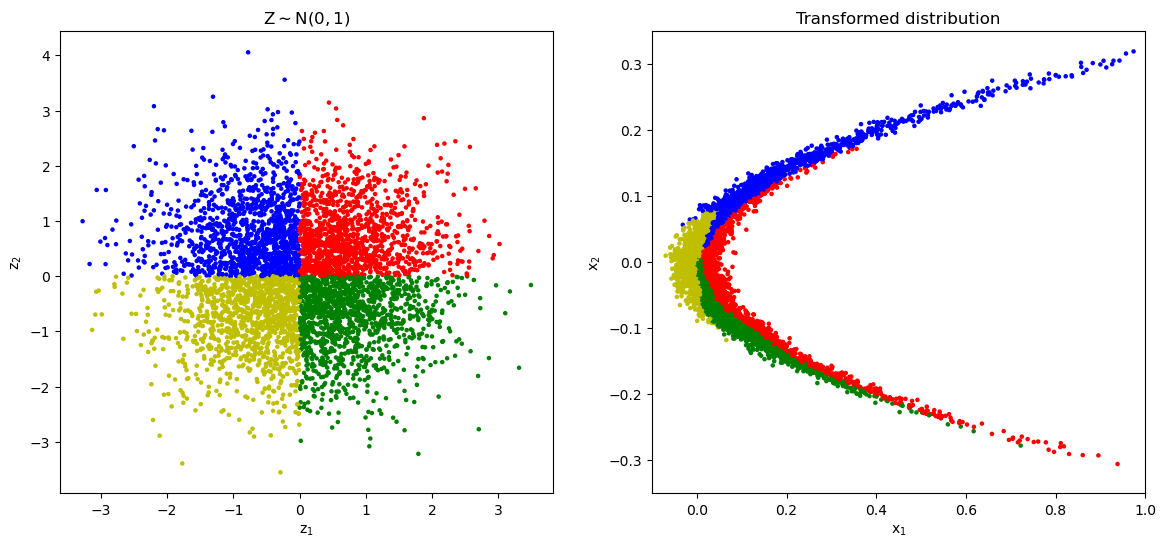

In [23]:
Z = np.random.normal(0, 1, (5000,2)).astype("float32")


def decide_color(row):
    if row[0] > 0 and row[1] > 0:
        return "r"
    if row[0] < 0 and row[1] > 0:
        return "b"
    if row[0] < 0 and row[1] < 0:
        return "y"
    return "g"


colors = [decide_color(x) for x in Z]
plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], s=5, c=colors)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = mar(Z)

plt.subplot(1, 2, 2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=colors)
plt.xlim(-0.1, 1)
plt.ylim(-0.35, 0.35)